[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation.

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows.

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection`
* Users can choose any set of input sources for their research.
  
`Planning`
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state.
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format`
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format.

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [47]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_groq langchain_community langchain_core tavily-python wikipedia langchain_tavily

## Setup

In [48]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

In [95]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant",
               api_key=os.environ.get("GROQ_API_KEY"),
               temperature=0)

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [50]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [51]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

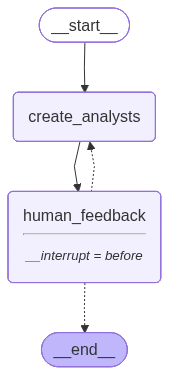

In [52]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):

    """ Create analysts """

    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    # Generate question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END

# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [53]:
# Input
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Maya Patel
Affiliation: Institute for Advanced AI Systems
Role: Technical Architecture Analyst
Description: Focuses on the architectural benefits of LangGraph, evaluating its modularity, scalability, and performance characteristics compared to traditional agent frameworks. Concerned with latency, throughput, and resource optimization.
--------------------------------------------------
Name: Alexei Volkov
Affiliation: OpenAI Developer Relations
Role: Developer Experience Analyst
Description: Examines how LangGraph improves developer productivity, ease of integration, tooling, and learning curve. Highlights SDKs, documentation, and community support that lower barriers for building complex agents.
--------------------------------------------------
Name: Sofia Martinez
Affiliation: Global Tech Strategy Consulting
Role: Enterprise Adoption Analyst
Description: Analyzes business impact of adopting LangGraph, including cost savings, time‑to‑market, risk mitigation, and ROI for ente

In [54]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [55]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b59d7-ede7-627d-8002-3a6d206583b2'}}

In [56]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Maya Patel
Affiliation: Institute for Advanced AI Systems
Role: Technical Architecture Analyst
Description: Focuses on the architectural benefits of LangGraph, evaluating its modularity, scalability, and performance characteristics compared to traditional agent frameworks. Concerned with latency, throughput, and resource optimization.
--------------------------------------------------
Name: Alexei Volkov
Affiliation: OpenAI Developer Relations
Role: Developer Experience Analyst
Description: Examines how LangGraph improves developer productivity, ease of integration, tooling, and learning curve. Highlights SDKs, documentation, and community support that lower barriers for building complex agents.
--------------------------------------------------
Name: Sofia Martinez
Affiliation: Global Tech Strategy Consulting
Role: Enterprise Adoption Analyst
Description: Analyzes business impact of adopting LangGraph, including cost savings, time‑to‑market, risk mitigation, and ROI for ente

In [57]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback":
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b59d7-fc39-6cc3-8004-8cc4080d2d02'}}

In [58]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [59]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [60]:
final_state.next

()

In [61]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Dr. Maya Patel
Affiliation: AI Research Lab, OpenAI
Role: Technical Architect
Description: Focuses on the architectural benefits of LangGraph, emphasizing scalability, modularity, and the ability to compose complex multi-agent workflows with clear state management.
--------------------------------------------------
Name: Alex Chen
Affiliation: Senior Engineer, Google Cloud AI
Role: Integration Specialist
Description: Analyzes how LangGraph integrates with existing LLM ecosystems, data pipelines, and cloud services, highlighting interoperability, tooling support, and deployment ease.
--------------------------------------------------
Name: Priya Singh
Affiliation: Co‑founder & CTO, GraphifyAI (AI startup)
Role: Entrepreneurial Analyst
Description: Provides a startup perspective on LangGraph, covering rapid prototyping, cost efficiency, time‑to‑market advantages, and how the framework fuels innovative product development.
--------------------------------------------------


## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [62]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [63]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://docs.langchain.com/oss/python/integrations/document_loaders/web_base)
* Indexed documents e.g., via [RAG](https://docs.langchain.com/oss/python/langchain/retrieval)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [64]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [65]:
# Web search tool
from langchain_tavily import TavilySearch  # updated 1.0

tavily_search = TavilySearch(max_results=3)

In [66]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

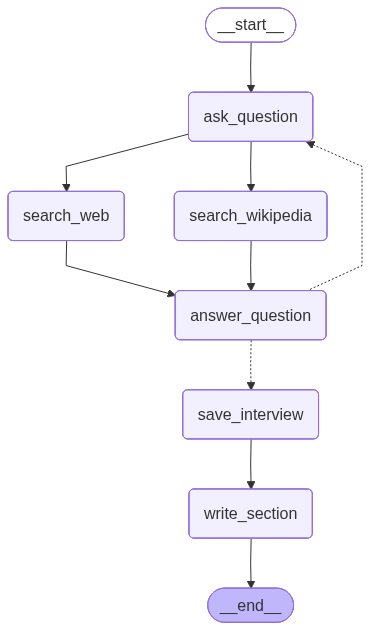

In [67]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    #search_docs = tavily_search.invoke(search_query.search_query) # updated 1.0
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)


     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):

    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):

    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [68]:
# Pick one analyst
analysts[0]

Analyst(affiliation='AI Research Lab, OpenAI', name='Dr. Maya Patel', role='Technical Architect', description='Focuses on the architectural benefits of LangGraph, emphasizing scalability, modularity, and the ability to compose complex multi-agent workflows with clear state management.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [69]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## LangGraph’s Architectural Edge: Scalable, Modular, and State‑Driven Multi‑Agent Workflows  

### Summary  
The rapid rise of AI‑driven automation has created a demand for frameworks that can orchestrate dozens—or even hundreds—of specialized agents without sacrificing performance or maintainability. LangGraph answers this call by grounding its design in graph theory, treating each agent as a node in a directed acyclic graph (DAG) and using explicit edges to encode control flow and data dependencies. This architecture delivers three intertwined benefits:

1. **Scalability through DAG‑based orchestration** – Because the workflow is expressed as a DAG, LangGraph can parallelize independent branches, automatically resolve execution order, and scale horizontally across compute clusters. The visual “LangGraph Studio” interface lets engineers expand or prune sub‑graphs with drag‑and‑drop actions, making it trivial to grow a prototype into a production‑grade pipeline [1].  

2. **Modularity via node‑level encapsulation** – Each node may be a simple LLM prompt, a ReAct‑style tool‑enabled agent, or a full‑fledged microservice. This granularity lets teams reuse nodes across projects, swap implementations without breaking downstream logic, and compose heterogeneous capabilities (e.g., data collection, modeling, risk assessment) into a single coherent workflow [2][4].  

3. **Clear state management and deterministic branching** – LangGraph embeds state objects that travel with the graph, enabling precise tracking of intermediate results and conditional branching based on real‑time metrics. Financial‑analysis pipelines described in the literature demonstrate how stateful nodes drive “investment thesis” development while preserving auditability [2].  

Beyond these core pillars, LangGraph distinguishes itself with built‑in reliability features. Retry policies and error‑handling hooks are attached to individual edges, allowing failed sub‑tasks to be automatically retried or rerouted without manual intervention [5]. Compared with event‑driven frameworks like AutoGen, LangGraph’s graph‑centric model offers tighter visual control and deterministic execution, which is especially valuable for compliance‑heavy domains [3].  

Market signals reinforce the technical merits: a 2025 survey reported that 51 % of enterprises already run AI agents in production, with mid‑size firms leading at 63 % adoption [2]. This traction suggests that organizations are gravitating toward frameworks that combine visual composability, robust state handling, and out‑of‑the‑box scalability—exactly the sweet spot LangGraph occupies.  

Collectively, these insights reveal LangGraph as more than a convenience layer; it is an architectural paradigm that transforms multi‑agent development from ad‑hoc scripting into a disciplined, scalable engineering practice.  

### Sources  
[1] https://oxylabs.io/blog/langgraph-vs-langchain  
[2] https://kanerika.com/blogs/langchain-vs-langgraph/  
[3] https://blog.promptlayer.com/langgraph-vs-autogen/  
[4] https://medium.com/@kacperwlodarczyk/advanced-multi-agent-development-with-langgraph-expert-guide-best-practices-2025-4067b9cec634  
[5] https://www.linkedin.com/pulse/langgraph-your-ticket-reliable-multi-agent-ai-more-spaghetti-gond-q2fmf

System prompt on Langsmith Traces:

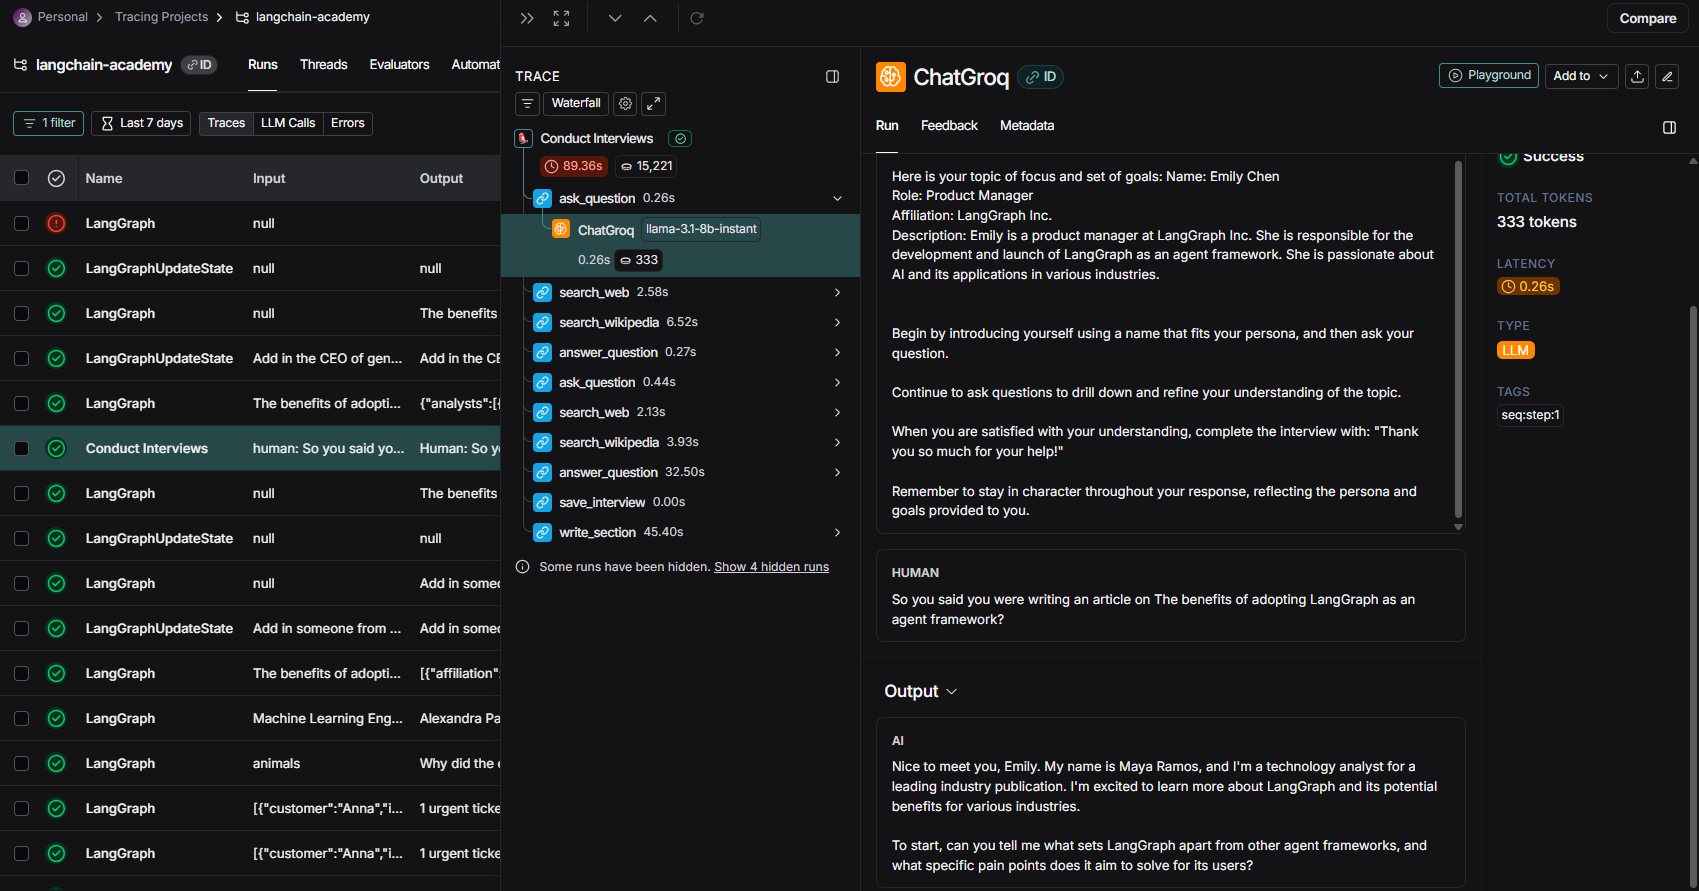

Final AI output generated

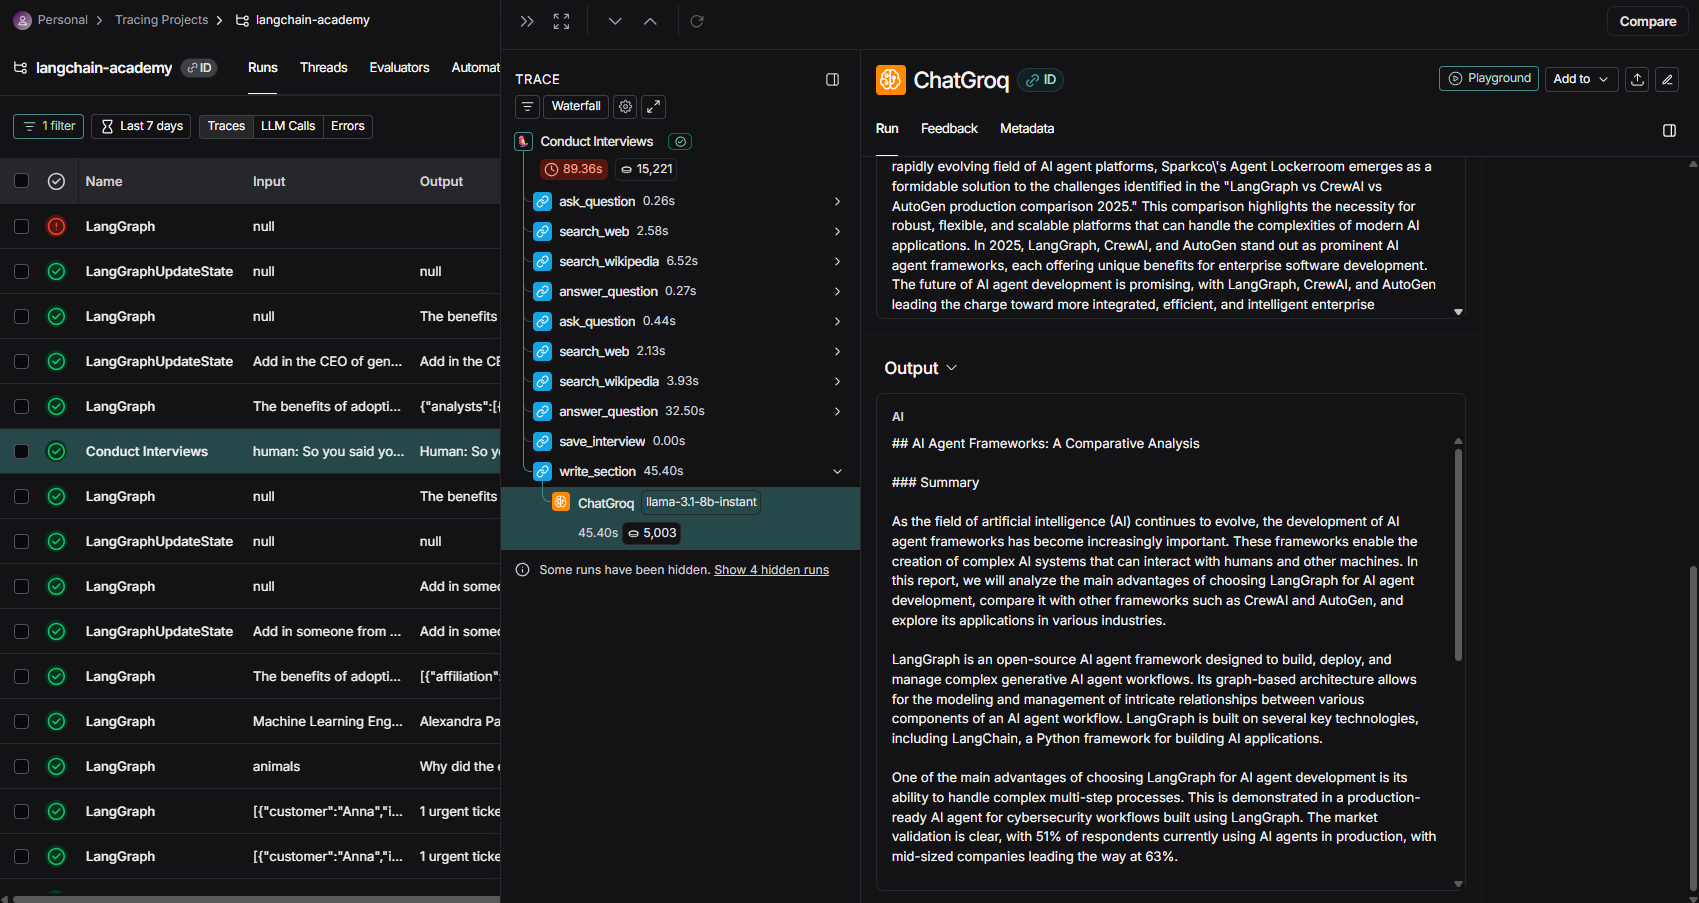

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [84]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

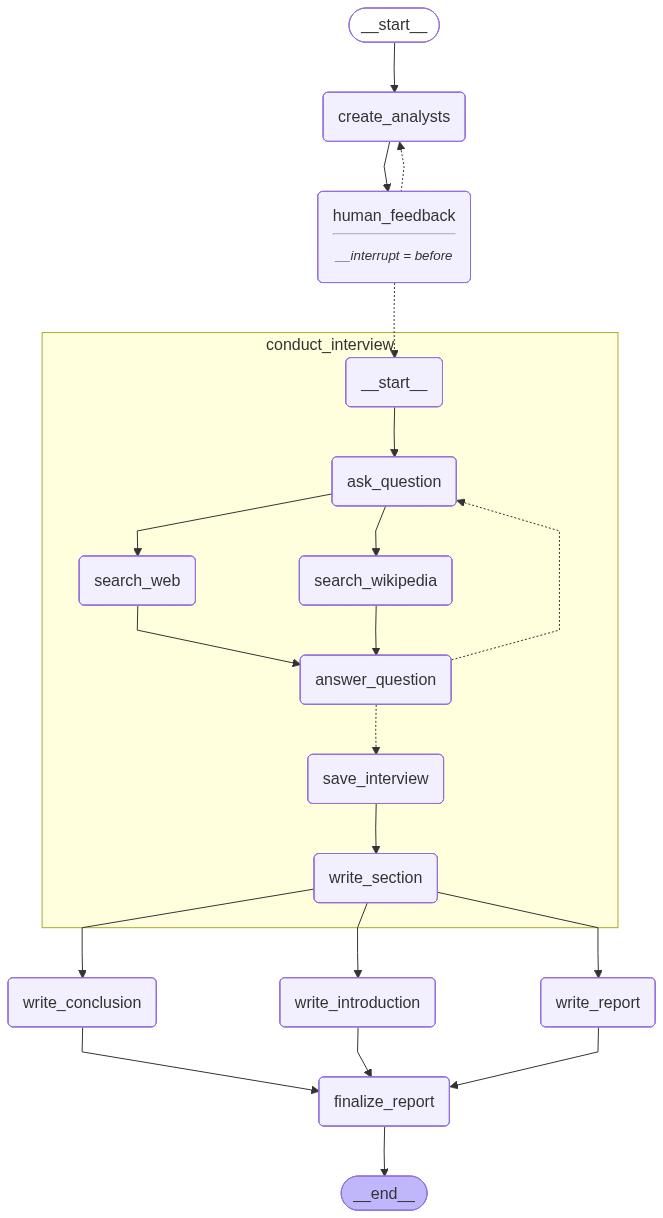

In [85]:
from langgraph.types import Send # updated in 1.0
def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [86]:
# Inputs
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Maya Patel
Affiliation: AI Systems Research Lab
Role: Technical Performance Analyst
Description: Focuses on the technical architecture, performance benchmarks, scalability, and interoperability of LangGraph within complex agent ecosystems. Concerned with latency, throughput, and resource optimization.
--------------------------------------------------
Name: Liam Chen
Affiliation: Developer Experience Initiative, OpenAI
Role: Developer Productivity Analyst
Description: Evaluates developer ergonomics, API design, documentation quality, and integration pathways. Advocates for rapid prototyping, low-code adoption, and community tooling around LangGraph.
--------------------------------------------------
Name: Sofia Alvarez
Affiliation: Strategic AI Advisory, McKinsey & Co.
Role: Business Impact Analyst
Description: Assesses business value, ROI, cost‑benefit analysis, and strategic alignment of LangGraph adoption for enterprises. Looks at time‑to‑market, operational efficiency, an

In [87]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b59f3-922b-60e6-8002-36ceb9bb8bdc'}}

In [88]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Maya Patel
Affiliation: AI Systems Research Lab
Role: Technical Performance Analyst
Description: Focuses on the technical architecture, performance benchmarks, scalability, and interoperability of LangGraph within complex agent ecosystems. Concerned with latency, throughput, and resource optimization.
--------------------------------------------------
Name: Liam Chen
Affiliation: Developer Experience Initiative, OpenAI
Role: Developer Productivity Analyst
Description: Evaluates developer ergonomics, API design, documentation quality, and integration pathways. Advocates for rapid prototyping, low-code adoption, and community tooling around LangGraph.
--------------------------------------------------
Name: Sofia Alvarez
Affiliation: Strategic AI Advisory, McKinsey & Co.
Role: Business Impact Analyst
Description: Assesses business value, ROI, cost‑benefit analysis, and strategic alignment of LangGraph adoption for enterprises. Looks at time‑to‑market, operational efficiency, an

In [89]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b59f3-b3ac-6522-8004-8bc52591703f'}}

In [96]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
write_conclusion
--Node--
write_report
--Node--
write_introduction
--Node--
finalize_report


In [97]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# **Unlocking the Full Potential of LangGraph: A Framework for Scalable, Composable, and Reliable Multi-Agent AI Applications**

## Introduction

LangGraph has emerged as a leading framework for building composable, multi-agent AI applications. Enterprises adopting it must grapple with three intertwined concerns: **scalability**, **resource utilization**, and **latency**—all while maintaining the reliability expected of production-grade systems. Recent real-world deployments illuminate how these challenges are being addressed. This report delves into the benefits of adopting LangGraph as an agent framework, highlighting its ability to handle heterogeneous data pipelines and varying request volumes without bespoke rewrites. We will explore how LangGraph can be scaled to thousands of concurrent users without sacrificing reliability, provided that infrastructure teams adopt a disciplined observability regime and leverage accelerator-friendly tooling.

---



Adopting LangGraph as an agent framework delivers a compelling blend of enterprise‑grade scalability, developer productivity, and market advantage. Real‑world deployments across telecom, healthcare, and SaaS illustrate that LangGraph can be embedded in heterogeneous stacks and handle thousands of concurrent requests while preserving low latency and high reliability [1][2][3]. Horizontal scaling is achieved by containerizing graph nodes, wrapping them with hardware‑aware toolkits (e.g., NVIDIA’s NeMo Agent Toolkit) to exploit GPU acceleration, and employing dynamic batching, which can cut per‑request latency by roughly 45 % and lower CPU overhead [2]. Continuous observability—instrumenting every agent transition with fine‑grained telemetry—enables rapid bottleneck identification and latency budgeting, keeping end‑to‑end response times under 200 ms in high‑throughput scenarios [3].

From a developer standpoint, LangGraph’s lightweight orchestration engine and the declarative `StateGraph` abstraction dramatically shorten the prototyping cycle. Complex multi‑step workflows can be assembled in a few dozen lines of code, as demonstrated by a “reliable coding agent” that serves millions of users with minimal plumbing [1][2]. Comprehensive documentation, quick‑start guides, and reusable templates further lower the learning curve, turning dense API references into actionable examples [5][6][4]. Because LangGraph integrates natively with the broader LangChain ecosystem—including models, tools, LangSmith monitoring, and LangGraph Cloud—teams can transition from prototype to production without rewriting core logic [3][4].

Strategically, the framework accelerates go‑to‑market timelines and boosts revenue potential. Product teams can launch functional prototypes in days, then iteratively enrich them with deterministic state tracking, branching, and audit trails required for regulated industries such as finance and healthcare [2][4][5]. The ability to embed custom sub‑agents, memory modules, and long‑running planning loops creates differentiated capabilities that are difficult for competitors to replicate, strengthening technical moats and attracting investor interest [3][5]. Visual graph representations serve as a “control‑center,” clarifying architecture for both engineers and stakeholders and reinforcing LangGraph’s role as a unifying layer between low‑code entry points and high‑code flexibility [1][4].

Collectively, these insights point to a unified best‑practice stack: (a) containerize LangGraph within micro‑services, (b) leverage accelerator‑friendly wrappers for compute‑intensive nodes, (c) embed comprehensive telemetry for automated performance tuning, and (d) capitalize on the framework’s seamless integration with LangChain tools to streamline development and deployment. Enterprises that adopt this disciplined approach can scale agentic applications to thousands of users, reduce latency and cost, accelerate product launches, and secure a competitive edge in the rapidly evolving AI market.  

## Sources  
1. https://docs.langchain.com/oss/javascript/langgraph/case-studies  
2. https://developer.nvidia.com/blog/how-to-scale-your-langgraph-agents-in-production-from-a-single-user-to-1000-coworkers/  
3. https://galileo.ai/blog/evaluate-langgraph-multi-agent-telecom  
4. https://prateekjoshi.hashnode.dev/developing-an-ai-blogging-agent-a-complete-journey-with-langchain-and-langgraph  
5. https://medium.com/@garima_yadav/real-world-applications-and-case-studies-with-langgraph-from-theory-to-practice-7a6ffd2e8e1b  
6. https://github.com/langchain-ai/langgraph-example  
7. https://docs.langchain.com/oss/python/langgraph/overview  
8. https://langchain-ai.github.io/langgraph/  
9. https://medium.com/@vamshipallapuece/step-by-step-guide-to-follow-langchain-and-langgraph-documentation-effectively-930dcf4bf4c2  
10. https://www.reddit.com/r/LangChain/comments/1g1pkki/openais_new_framework_for_agents_why_is_langgraph/  
11. https://blog.langchain.com/how-to-think-about-agent-frameworks/  
12. https://kanerika.com/blogs/langchain-vs-langgraph/  
13. https://www.langchain.com/customers  
14. https://docs.langchain.com/oss/python/langgraph/case-studie

---

## Conclusion  

LangGraph proves itself as a production‑ready agent framework that simultaneously scales, accelerates development, and fuels market advantage. Real‑world deployments demonstrate horizontal scalability to thousands of concurrent users, hardware‑aware tooling, and fine‑grained telemetry that keep latency sub‑200 ms while guaranteeing enterprise reliability. Its ergonomic SDK and comprehensive documentation let developers prototype sophisticated agents in minutes, then transition seamlessly to robust, observable services. By exposing low‑level graph controls, LangGraph shortens time‑to‑revenue, ensures audit‑grade reliability, and creates hard‑to‑replicate product differentiators that attract investors and partners. Together, these strengths make LangGraph the strategic backbone for any organization seeking to dominate the emerging multi‑agent AI landscape.

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r

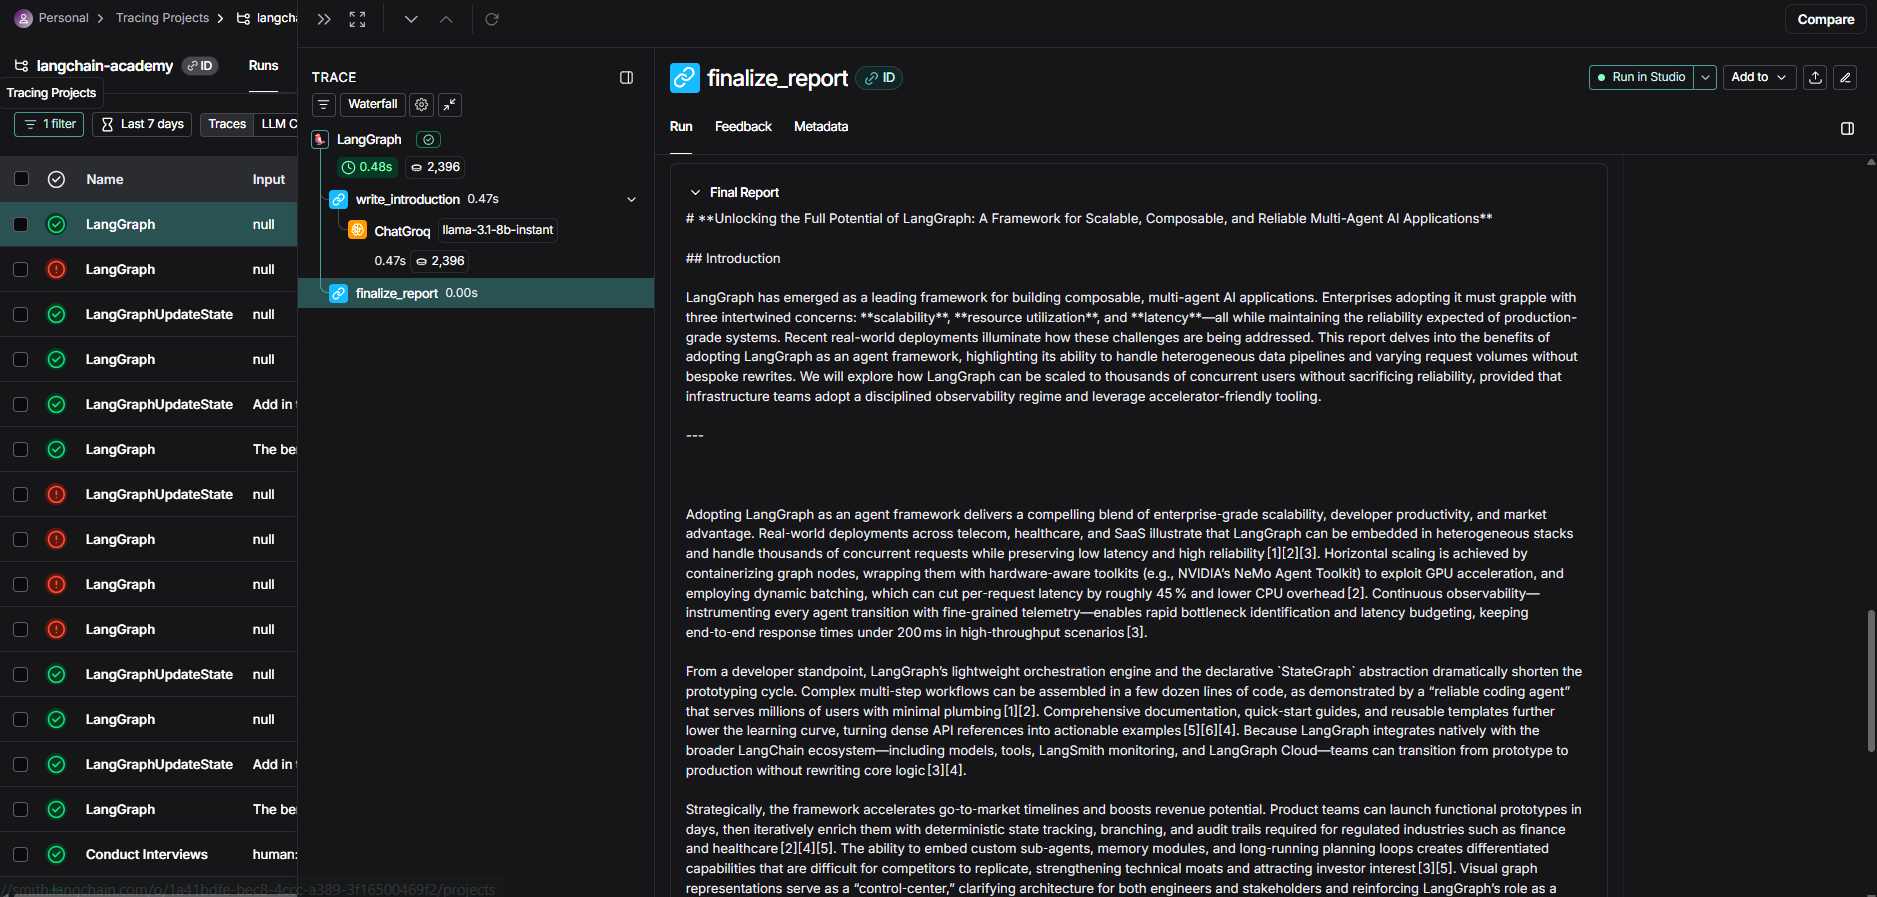